In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold,cross_validate,train_test_split

from sklearn.metrics import confusion_matrix,f1_score
import time
import random
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#for data preprocessing
from sklearn.decomposition import PCA

#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

#filter warnings
import warnings
warnings.filterwarnings("ignore")

path_raw_data = r'C:\Users\sam32564\raw_data_credit'
# path_processed_data = '../Data/processed'
# path_prediction_data = '../Data/predictions'
col_target = 'fraud_ind'
col_id = 'txkey'
pd.options.display.max_columns=None

In [2]:
time_start = time.time()
df = pd.read_csv(os.path.join(path_raw_data, 'train.csv'))
#X = np.array(df_train.drop('fraud_ind',axis=1))
y = np.array(df.fraud_ind)
df_train, df_test, y_train, y_test = train_test_split(df,y,test_size=0.3,random_state=42)
time_end = time.time()
print('spent: {}'.format(time_end-time_start))

spent: 6.361618280410767


In [3]:
df_train_id = df_train[col_id]
df_test_id = df_test[col_id]
target = df_train[col_target]

df_train.drop([col_id], axis = 1, inplace = True)
df_test.drop([col_id], axis = 1, inplace = True)

In [4]:
df_train = df_train.drop_duplicates(keep = 'first')
ntrain = df_train.shape[0]

In [5]:
df_full = pd.concat((df_train,df_test),sort = False).reset_index(drop = True)
print(df_train.shape, df_test.shape, df_full.shape)

(1062697, 22) (456537, 22) (1519234, 22)


# EDA

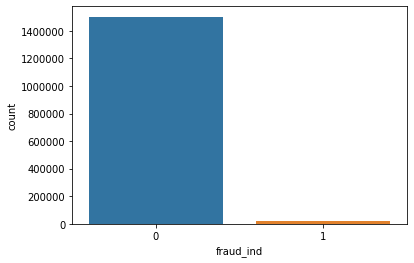

0    1501432
1      20355
Name: fraud_ind, dtype: int64


In [6]:
df = pd.read_csv(os.path.join(path_raw_data, 'train.csv'))
sns.countplot(df.fraud_ind)
plt.show()
print(df.fraud_ind.value_counts())

# preprocessing

## 變數組合

In [7]:
# generate time feature ( format hhmmss)
df_full['loctm_time'] = df_full['loctm'].apply(lambda x: '0'*(6 - len(str(int(x)))) + str(int(x)))
df_full['loctm_time'] = df_full['loctm_time'].apply(lambda x: x[:2] + ':' + x[2:4] + ':' + x[4:])
df_full['loctm_time'] = pd.to_datetime(df_full['loctm_time'], format='%H:%M:%S')

In [8]:
df_full.insert(3,'time_hour', df_full['loctm_time'].dt.hour)
df_full.insert(3,'time_min', df_full['loctm_time'].dt.minute)
df_full.insert(3,'time_sec', df_full['loctm_time'].dt.second)

In [9]:
df_full.head()

,acqic,bacno,cano,time_sec,time_min,time_hour,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,loctm_time
0,6557,51892,58488,8,6,21,497.33,5,62,N,4,N,N,0,5,N,0,50,210608.0,251,31635,N,5817,102,0,1900-01-01 21:06:08
1,5975,65754,58218,12,3,12,718.77,5,62,N,4,N,N,0,5,N,0,85,120312.0,193,99026,N,5817,102,0,1900-01-01 12:03:12
2,6716,163544,117141,39,1,18,807.34,5,62,Y,2,N,N,0,5,N,0,6,180139.0,57,34227,N,5820,102,0,1900-01-01 18:01:39
3,6716,52788,8114,39,57,9,1110.00,4,62,N,2,N,N,0,5,N,0,5,95739.0,317,35002,N,5817,102,0,1900-01-01 09:57:39
4,6716,62527,147619,32,57,15,669.38,5,62,N,5,N,N,0,5,N,0,25,155732.0,247,48833,N,5859,102,0,1900-01-01 15:57:32


In [10]:
df_full['fraud_y_1hours'] = df_full.fraud_ind[(df_full['time_hour']<1) & (df_full['fraud_ind']==1)]
df_full['fraud_y_12hours'] = df_full.fraud_ind[(df_full['time_hour']<12) & (df_full['fraud_ind']==1)]
df_full['fraud_y_24hours'] = df_full.fraud_ind[(df_full['time_hour']<24) & (df_full['fraud_ind']==1)]
df_full['fraud_y_5days'] = df_full.fraud_ind[(df_full['locdt']<5) & (df_full['fraud_ind']==1)]
df_full['fraud_y_10days'] = df_full.fraud_ind[(df_full['locdt']<10) & (df_full['fraud_ind']==1)]
df_full['fraud_y_20days'] = df_full.fraud_ind[(df_full['locdt']<20) & (df_full['fraud_ind']==1)]
df_full = df_full.fillna(0)

In [11]:
df_full['fraud_y_stscd'] = df_full.fraud_ind[(df_full['stscd']>0) & (df_full['fraud_ind']==1)]
df_full['fraud_y_flbmk'] = df_full.fraud_ind[(df_full['flbmk']=='Y') & (df_full['fraud_ind']==1)]
df_full['fraud_y_etymd'] = df_full.fraud_ind[(df_full['etymd']>1) & (df_full['fraud_ind']==1)]
df_full['fraud_y_ecfg'] = df_full.fraud_ind[(df_full['ecfg']=='Y') & (df_full['fraud_ind']==1)]
df_full['fraud_y_ovrlt'] = df_full.fraud_ind[(df_full['ovrlt']=='Y') & (df_full['fraud_ind']==1)]
df_full['fraud_y_flg_3dsmk'] = df_full.fraud_ind[(df_full['flg_3dsmk']=='Y') & (df_full['fraud_ind']==1)]
df_full['fraud_y_insfg'] = df_full.fraud_ind[(df_full['insfg']=='Y') & (df_full['fraud_ind']==1)]
df_full = df_full.fillna(0)

In [12]:
fraud_mean = df_full.groupby('fraud_ind')['conam'].mean()
fraud_median = df_full.groupby('fraud_ind')['conam'].median()
df_full['fraud_mean_conam'] = df_full.fraud_ind[(df_full.conam>fraud_mean[1]) & (df_full.fraud_ind ==1)]
df_full['fraud_median_conam'] = df_full.fraud_ind[(df_full.conam>fraud_median[1]) & (df_full.fraud_ind ==1)]
df_full = df_full.fillna(0)

## Groupby bacno with other feature

In [13]:
bycol_num = 1
df_full_groupby = df_full.groupby(['bacno']).agg(
    {'conam':['max','min','sum','count','mean','median']})

df_full_groupby.columns = df_full_groupby.columns.droplevel()
df_full_groupby.reset_index(inplace = True)

In [14]:
col_feature = df_full_groupby.columns.tolist()
for i in range(len(col_feature[bycol_num:])):
    col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bybacno'

df_full_groupby.columns = col_feature

In [15]:
df_full = df_full.merge(df_full_groupby, on = ['bacno'], how = 'left')

In [16]:
df_full.head()

,acqic,bacno,cano,time_sec,time_min,time_hour,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,loctm_time,fraud_y_1hours,fraud_y_12hours,fraud_y_24hours,fraud_y_5days,fraud_y_10days,fraud_y_20days,fraud_y_stscd,fraud_y_flbmk,fraud_y_etymd,fraud_y_ecfg,fraud_y_ovrlt,fraud_y_flg_3dsmk,fraud_y_insfg,fraud_mean_conam,fraud_median_conam,max_bybacno,min_bybacno,sum_bybacno,count_bybacno,mean_bybacno,median_bybacno
0,6557,51892,58488,8,6,21,497.33,5,62,N,4,N,N,0,5,N,0,50,210608.0,251,31635,N,5817,102,0,1900-01-01 21:06:08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1271.91,373.76,11531.74,16,720.733750,659.12
1,5975,65754,58218,12,3,12,718.77,5,62,N,4,N,N,0,5,N,0,85,120312.0,193,99026,N,5817,102,0,1900-01-01 12:03:12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1217.35,535.31,6637.80,8,829.725000,718.77
2,6716,163544,117141,39,1,18,807.34,5,62,Y,2,N,N,0,5,N,0,6,180139.0,57,34227,N,5820,102,0,1900-01-01 18:01:39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1465.15,241.54,23772.31,35,679.208857,697.12
3,6716,52788,8114,39,57,9,1110.00,4,62,N,2,N,N,0,5,N,0,5,95739.0,317,35002,N,5817,102,0,1900-01-01 09:57:39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1555.60,634.68,23726.14,20,1186.307000,1200.82
4,6716,62527,147619,32,57,15,669.38,5,62,N,5,N,N,0,5,N,0,25,155732.0,247,48833,N,5859,102,0,1900-01-01 15:57:32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1130.89,240.27,27546.19,41,671.858293,680.57


### Fillna

In [17]:
# Fill NaN, 此处排除 fraud_ind
for col in df_full.columns:
    if col != 'fraud_ind':
        df_full[col] = df_full[col].fillna(0)

In [18]:
df_full['fraud_ind'].isnull().sum()

0

### drop columns

In [19]:
df_full.columns

Index(['acqic', 'bacno', 'cano', 'time_sec', 'time_min', 'time_hour', 'conam',
       'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'fraud_ind',
       'hcefg', 'insfg', 'iterm', 'locdt', 'loctm', 'mcc', 'mchno', 'ovrlt',
       'scity', 'stocn', 'stscd', 'loctm_time', 'fraud_y_1hours',
       'fraud_y_12hours', 'fraud_y_24hours', 'fraud_y_5days', 'fraud_y_10days',
       'fraud_y_20days', 'fraud_y_stscd', 'fraud_y_flbmk', 'fraud_y_etymd',
       'fraud_y_ecfg', 'fraud_y_ovrlt', 'fraud_y_flg_3dsmk', 'fraud_y_insfg',
       'fraud_mean_conam', 'fraud_median_conam', 'max_bybacno', 'min_bybacno',
       'sum_bybacno', 'count_bybacno', 'mean_bybacno', 'median_bybacno'],
      dtype='object')

In [20]:
# 檢查有na的columns
df_full.loc[:,df_full.columns[df_full.isnull().sum()>0]].isnull().sum()

Series([], dtype: float64)

In [21]:
df_full.drop(['bacno','cano','locdt','loctm','time_sec','time_min','loctm_time','ecfg','flbmk','flg_3dsmk','insfg','ovrlt'
             ],axis=1,inplace=True)

In [22]:
print(df_full.shape)
df_full.head()

(1519234, 35)


,acqic,time_hour,conam,contp,csmcu,etymd,fraud_ind,hcefg,iterm,mcc,mchno,scity,stocn,stscd,fraud_y_1hours,fraud_y_12hours,fraud_y_24hours,fraud_y_5days,fraud_y_10days,fraud_y_20days,fraud_y_stscd,fraud_y_flbmk,fraud_y_etymd,fraud_y_ecfg,fraud_y_ovrlt,fraud_y_flg_3dsmk,fraud_y_insfg,fraud_mean_conam,fraud_median_conam,max_bybacno,min_bybacno,sum_bybacno,count_bybacno,mean_bybacno,median_bybacno
0,6557,21,497.33,5,62,4,0,5,0,251,31635,5817,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1271.91,373.76,11531.74,16,720.733750,659.12
1,5975,12,718.77,5,62,4,0,5,0,193,99026,5817,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1217.35,535.31,6637.80,8,829.725000,718.77
2,6716,18,807.34,5,62,2,0,5,0,57,34227,5820,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1465.15,241.54,23772.31,35,679.208857,697.12
3,6716,9,1110.00,4,62,2,0,5,0,317,35002,5817,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1555.60,634.68,23726.14,20,1186.307000,1200.82
4,6716,15,669.38,5,62,5,0,5,0,247,48833,5859,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1130.89,240.27,27546.19,41,671.858293,680.57


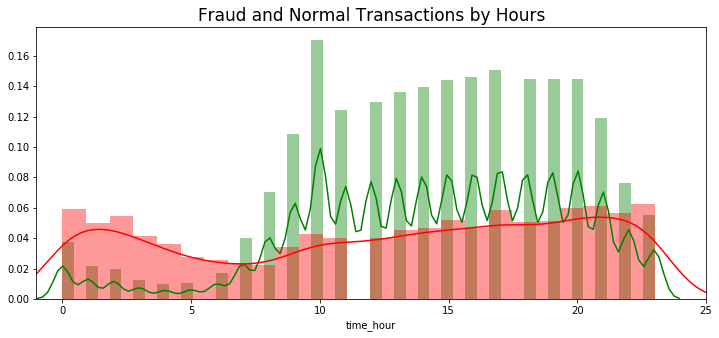

In [23]:
plt.figure(figsize=(12,5))
sns.distplot(df_full[df_full['fraud_ind'] == 0]["time_hour"], color='g')
sns.distplot(df_full[df_full['fraud_ind'] == 1]["time_hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

In [24]:
cols= df_full[['time_hour', 'conam']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

df_full['V29']=X_PCA[:,0]
df_full['V30']=X_PCA[:,1]

df_full.drop(['time_hour', 'conam'], axis=1, inplace=True)

df_full.columns

Index(['acqic', 'contp', 'csmcu', 'etymd', 'fraud_ind', 'hcefg', 'iterm',
       'mcc', 'mchno', 'scity', 'stocn', 'stscd', 'fraud_y_1hours',
       'fraud_y_12hours', 'fraud_y_24hours', 'fraud_y_5days', 'fraud_y_10days',
       'fraud_y_20days', 'fraud_y_stscd', 'fraud_y_flbmk', 'fraud_y_etymd',
       'fraud_y_ecfg', 'fraud_y_ovrlt', 'fraud_y_flg_3dsmk', 'fraud_y_insfg',
       'fraud_mean_conam', 'fraud_median_conam', 'max_bybacno', 'min_bybacno',
       'sum_bybacno', 'count_bybacno', 'mean_bybacno', 'median_bybacno', 'V29',
       'V30'],
      dtype='object')

In [26]:
columns = ['fraud_ind','fraud_y_1hours','fraud_y_12hours','fraud_y_24hours','fraud_y_5days','fraud_y_10days','fraud_y_20days', 'fraud_y_stscd', 'fraud_y_flbmk', 'fraud_y_etymd',
       'fraud_y_ecfg', 'fraud_y_ovrlt', 'fraud_y_flg_3dsmk', 'fraud_y_insfg',
       'fraud_mean_conam', 'fraud_median_conam']
df_full #= df_full.drop([columns],axis=1)

,acqic,contp,csmcu,etymd,fraud_ind,hcefg,iterm,mcc,mchno,scity,stocn,stscd,fraud_y_1hours,fraud_y_12hours,fraud_y_24hours,fraud_y_5days,fraud_y_10days,fraud_y_20days,fraud_y_stscd,fraud_y_flbmk,fraud_y_etymd,fraud_y_ecfg,fraud_y_ovrlt,fraud_y_flg_3dsmk,fraud_y_insfg,fraud_mean_conam,fraud_median_conam,max_bybacno,min_bybacno,sum_bybacno,count_bybacno,mean_bybacno,median_bybacno,V29,V30
0,6557,5,62,4,0,5,0,251,31635,5817,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1271.91,373.76,11531.74,16,720.733750,659.12,-157.540978,-6.673364
1,5975,5,62,4,0,5,0,193,99026,5817,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1217.35,535.31,6637.80,8,829.725000,718.77,63.898244,2.345755
2,6716,5,62,2,0,5,0,57,34227,5820,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1465.15,241.54,23772.31,35,679.208857,697.12,152.468762,-3.646598
3,6716,4,62,2,0,5,0,317,35002,5817,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1555.60,634.68,23726.14,20,1186.307000,1200.82,455.127984,5.379534
4,6716,5,62,5,0,5,0,247,48833,5859,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1130.89,240.27,27546.19,41,671.858293,680.57,14.508504,-0.658509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519229,5975,5,62,4,0,5,0,193,94602,5817,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1727.57,377.38,9260.64,16,578.790000,518.22,1072.698154,3.432855
1519230,6189,5,62,5,0,5,0,263,98452,5817,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,766.30,224.48,8641.88,18,480.104444,546.16,-402.261236,-3.694493
1519231,6716,5,62,4,0,5,0,247,34404,5820,102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1420.37,680.57,12148.88,13,934.529231,927.77,107.588417,0.349527
1519232,3271,5,62,8,0,5,0,203,73652,6012,38,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1938.63,0.00,29302.05,34,861.825000,731.24,774.218846,-4.592916


In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_full)
X_scaled = scaler.transform(df_full)

In [31]:
columns

Index(['acqic', 'contp', 'csmcu', 'etymd', 'hcefg', 'iterm', 'mcc', 'mchno',
       'scity', 'stocn', 'stscd', 'fraud_y_1hours', 'fraud_y_12hours',
       'fraud_y_24hours', 'fraud_y_5days', 'fraud_y_10days', 'fraud_y_20days',
       'fraud_y_stscd', 'fraud_y_flbmk', 'fraud_y_etymd', 'fraud_y_ecfg',
       'fraud_y_ovrlt', 'fraud_y_flg_3dsmk', 'fraud_y_insfg',
       'fraud_mean_conam', 'fraud_median_conam', 'max_bybacno', 'min_bybacno',
       'sum_bybacno', 'count_bybacno', 'mean_bybacno', 'median_bybacno', 'V29',
       'V30'],
      dtype='object')

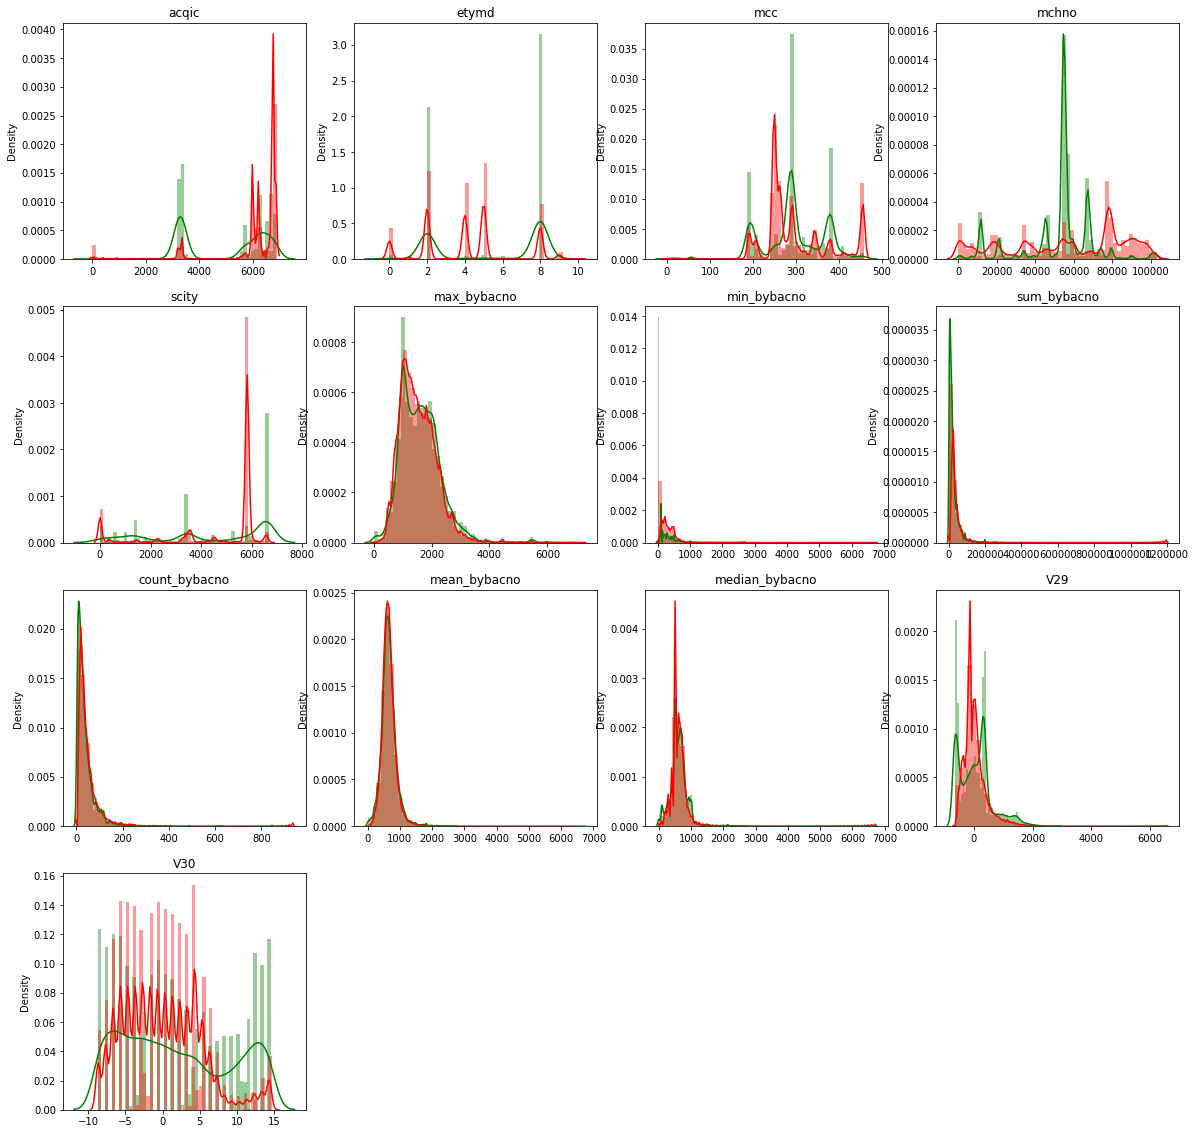

In [39]:
columns = df_full.drop(['fraud_ind','contp','csmcu','hcefg','iterm','stocn','stscd','fraud_y_1hours', 'fraud_y_12hours',
       'fraud_y_24hours', 'fraud_y_5days', 'fraud_y_10days', 'fraud_y_20days',
       'fraud_y_stscd', 'fraud_y_flbmk', 'fraud_y_etymd', 'fraud_y_ecfg',
       'fraud_y_ovrlt', 'fraud_y_flg_3dsmk', 'fraud_y_insfg',
       'fraud_mean_conam', 'fraud_median_conam'],axis=1).columns

grid = gridspec.GridSpec(4,4)

plt.figure(figsize=(20,10*2))

for n, col in enumerate(df_full[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df_full[df_full.fraud_ind==1][col], bins = 50, color='g')
    sns.distplot(df_full[df_full.fraud_ind==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

In [40]:
def ztest(feature):
    
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))
    
    return zScore

In [41]:
normal= df_full[df_full.fraud_ind==0]
fraud= df_full[df_full.fraud_ind==1]
sample_size=len(fraud)
significant_features=[]
critical_value=2.58

for i in columns:
    
    z_vavlue=ztest(i)
    
    if( abs(z_vavlue) >= critical_value):    
        print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        significant_features.append(i)

acqic  is statistically significant
etymd  is statistically significant
mcc  is statistically significant
mchno  is statistically significant
scity  is statistically significant
max_bybacno  is statistically significant
min_bybacno  is statistically significant
sum_bybacno  is statistically significant
count_bybacno  is statistically significant
mean_bybacno  is statistically significant
median_bybacno  is statistically significant
V29  is statistically significant
V30  is statistically significant


In [42]:
significant_features.append('fraud_ind')
df_sign= df_full[significant_features]

inliers = df_sign[df_sign.fraud_ind==0]
ins = inliers.drop(['fraud_ind'], axis=1)

outliers = df_sign[df_sign.fraud_ind==1]
outs = outliers.drop(['fraud_ind'], axis=1)

ins.shape, outs.shape

((1498953, 13), (20281, 13))

In [43]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

In [44]:
state= 42

ISF = IsolationForest(random_state=state)
ISF.fit(ins)

normal_isf = ISF.predict(ins)
fraud_isf = ISF.predict(outs)

in_accuracy_isf=normal_accuracy(normal_isf)
out_accuracy_isf=fraud_accuracy(fraud_isf)
print("Accuracy in Detecting Normal Cases:", in_accuracy_isf)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_isf)

Accuracy in Detecting Normal Cases: 0.8527
Accuracy in Detecting Fraud Cases: 0.3715


In [45]:
LOF = LocalOutlierFactor(novelty=True)
LOF.fit(ins)

normal_lof = LOF.predict(ins)
fraud_lof = LOF.predict(outs)

in_accuracy_lof=normal_accuracy(normal_lof)
out_accuracy_lof=fraud_accuracy(fraud_lof)
print("Accuracy in Detecting Normal Cases:", in_accuracy_lof)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_lof)

Accuracy in Detecting Normal Cases: 0.9483
Accuracy in Detecting Fraud Cases: 0.2635


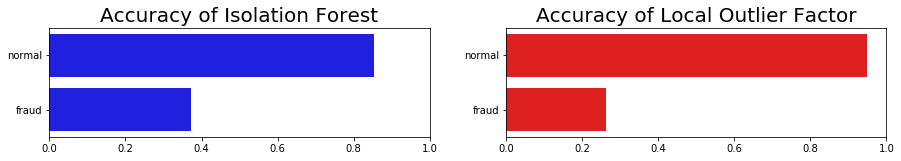

In [46]:
fig, (ax1,ax2)= plt.subplots(1,2, figsize=[15,2])

ax1.set_title("Accuracy of Isolation Forest",fontsize=20)
sns.barplot(x=[in_accuracy_isf,out_accuracy_isf], 
            y=['normal', 'fraud'],
            label="classifiers", 
            color="b", 
            ax=ax1)
ax1.set(xlim=(0,1))

ax2.set_title("Accuracy of Local Outlier Factor",fontsize=20)
sns.barplot(x=[in_accuracy_lof,out_accuracy_lof], 
            y=['normal', 'fraud'], 
            label="classifiers", 
            color="r", 
            ax=ax2)
ax2.set(xlim=(0,1))
plt.show()